In [2]:
import glob
import pandas as pd
import os
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
# Already previously filtered
# Create the output directory if it doesn't already exist
# output_dir = '/Volumes/T7/filtered_dispatch_output'
# os.makedirs(output_dir, exist_ok=True)

# # List all Parquet files in the directory
# file_list = glob.glob('/Volumes/T7/batch-parquet-data/*.parquet')

# for file in file_list:
#     print(f"Processing {file}...")
#     df = pd.read_parquet(file)
    
#     # Convert columns to numeric
#     df['LOWERREG'] = pd.to_numeric(df['LOWERREG'], errors='coerce')
#     df['RAISEREG'] = pd.to_numeric(df['RAISEREG'], errors='coerce')

#     # Filter out rows where both LOWERREG and RAISEREG are 0
#     filtered_df = df[~((df['LOWERREG'] == 0) & (df['RAISEREG'] == 0))]

#     # Print the first few rows of the filtered DataFrame
#     print("Filtered DataFrame head:")
#     print(filtered_df.head())

#     # Construct a new output file path
#     out_file = file.replace('batch-parquet-data', 'filtered_dispatch_output')

#     # Save filtered DataFrame to the new directory
#     filtered_df.to_parquet(out_file, index=False)
#     print(f"Finished processing {file}.\n")

In [4]:
# More efficient to keep ddf in separate partions
print("Reading filtered Parquet files into a Dask DataFrame...")
ddf = dd.read_parquet(
    '/Volumes/T7/dispatch_data/filtered_dispatch_output')
print("Done reading files.")

# Check available columns to ensure 'SETTLEMENTDATE' exists
print("Columns in the DataFrame:", ddf.columns)
print(ddf.head())

Reading filtered Parquet files into a Dask DataFrame...
Done reading files.
Columns in the DataFrame: Index(['SETTLEMENTDATE', 'DUID', 'INTERVENTION', 'DISPATCHMODE', 'AGCSTATUS',
       'INITIALMW', 'TOTALCLEARED', 'RAMPDOWNRATE', 'RAMPUPRATE', 'LOWER5MIN',
       'LOWER60SEC', 'LOWER6SEC', 'RAISE5MIN', 'RAISE60SEC', 'RAISE6SEC',
       'LOWERREG', 'RAISEREG', 'AVAILABILITY', 'RAISEREGENABLEMENTMAX',
       'RAISEREGENABLEMENTMIN', 'LOWERREGENABLEMENTMAX',
       'LOWERREGENABLEMENTMIN', 'SEMIDISPATCHCAP'],
      dtype='object')
        SETTLEMENTDATE  DUID INTERVENTION DISPATCHMODE AGCSTATUS  INITIALMW  \
0  2009/12/01 00:05:00  BW01            0            0         1   416.3204   
1  2009/12/01 00:05:00  BW02            0            0         1  410.21045   
2  2009/12/01 00:05:00  BW03            0            0         1  417.33316   
3  2009/12/01 00:05:00  BW04            0            0         1  397.92529   
4  2009/12/01 00:05:00  ER01            0            0         1  594

In [5]:
# Create monthly sum and save output as groupby is costly operation

# 2) Use 'SETTLEMENTDATE' as the date column
date_col = 'SETTLEMENTDATE'
if date_col not in ddf.columns:
    raise KeyError(f"The column '{date_col}' does not exist in the DataFrame. Please verify the column names.")

print(f"Converting '{date_col}' column to datetime format...")
ddf[date_col] = dd.to_datetime(ddf[date_col])
print("Date conversion complete.")

print("Creating 'year_month' column...")
ddf['year_month'] = ddf[date_col].dt.strftime('%Y-%m')
print("year_month column created.")

print("Grouping by 'year_month' and summing RAISEREG and LOWERREG columns...")
monthly_sums = ddf.groupby('year_month')[['RAISEREG', 'LOWERREG']].sum().compute()
monthly_sums = monthly_sums.sort_index()
print("Grouping complete. Monthly sums computed:")
print(monthly_sums.head())

# 3) Save monthly_sums to a Parquet file
output_path = "/Volumes/T7/dispatch_data/monthly_sums.parquet"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

print(f"Saving monthly_sums to {output_path}...")
monthly_sums.to_parquet(output_path)
print("File saved successfully!")

Converting 'SETTLEMENTDATE' column to datetime format...
Date conversion complete.
Creating 'year_month' column...
year_month column created.
Grouping by 'year_month' and summing RAISEREG and LOWERREG columns...
Grouping complete. Monthly sums computed:
              RAISEREG    LOWERREG
year_month                        
2009-12     1368682.03  1077563.46
2010-01     1763476.21  1082402.40
2010-02     1577421.34   981213.94
2010-03     1743390.31  1083819.12
2010-04     1847407.05  1191223.16
Saving monthly_sums to /Volumes/T7/dispatch_data/monthly_sums.parquet...
File saved successfully!


In [7]:
monthly_sums = monthly_sums.iloc[:-1]

In [8]:
monthly_sums.tail()

,RAISEREG,LOWERREG
year_month,,
2024-03,2.010354e+06,2.159184e+06
2024-04,2.060363e+06,2.020382e+06
2024-05,2.066317e+06,2.082776e+06
2024-06,1.989303e+06,1.990350e+06
2024-07,2.039591e+06,2.138558e+06


In [9]:
stats = ddf[['RAISEREG', 'LOWERREG']].describe().compute()
print(stats)

           RAISEREG      LOWERREG
count  4.212030e+07  4.212030e+07
mean   7.505451e+00  6.235333e+00
std    8.828479e+00  8.854818e+00
min    0.000000e+00  0.000000e+00
25%    2.233520e+00  1.000000e+00
50%    8.000000e+00  5.000000e+00
75%    1.400000e+01  1.000000e+01
max    2.500000e+02  2.400000e+02


/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_14536/829535311.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tick_dates = pd.date_range(start=start_tick, end=end_tick, freq='12M')  # every 12 months


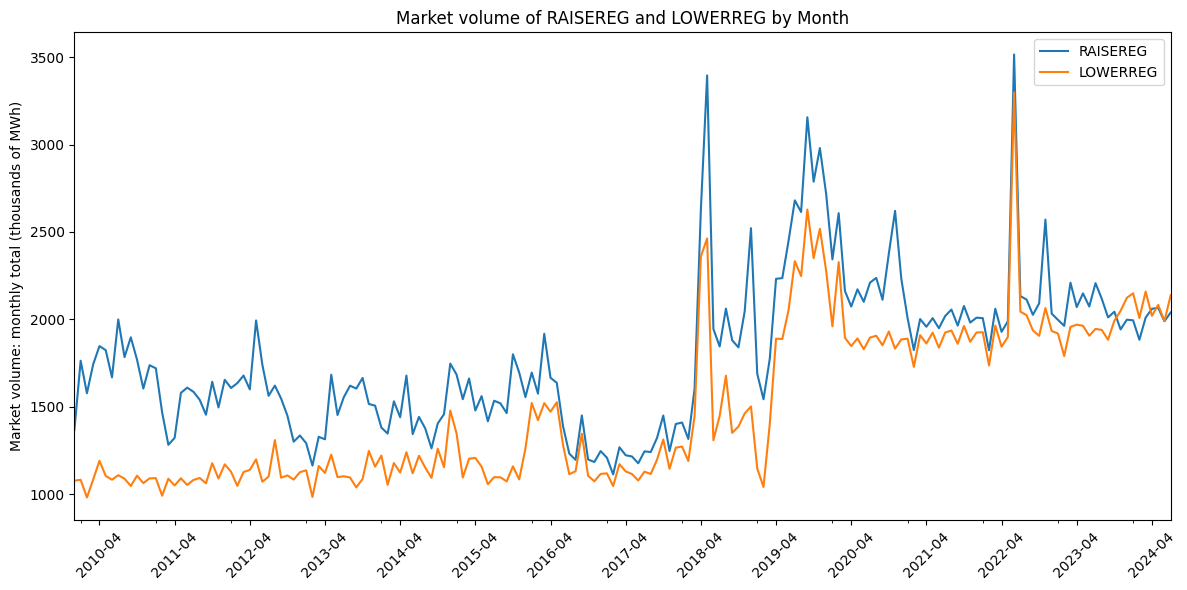

In [14]:
# 1) Convert index to a proper datetime index if it’s still strings like 'YYYY-MM'
monthly_sums.index = pd.to_datetime(monthly_sums.index, format='%Y-%m')

# 2) Convert RAISEREG and LOWERREG to thousands of MWh
# 2) Create a copy and scale only the copy
# Something funny happening with the scale. Originally needed to divide by 1000 and then was scaled down ?x,
# Now need to scale up 1x
# Following should now be correct
monthly_sums_scaled = monthly_sums.copy()
monthly_sums_scaled[['RAISEREG', 'LOWERREG']] /= 1000

# 3) Plot two separate lines for RAISEREG and LOWERREG
fig, ax = plt.subplots(figsize=(12, 6))
monthly_sums_scaled[['RAISEREG', 'LOWERREG']].plot(ax=ax, kind='line')

# 4) Customize labels and title
ax.set_title("Market volume of RAISEREG and LOWERREG by Month")
ax.set_ylabel("Market volume: monthly total (thousands of MWh)")

# 5) Set custom x-axis ticks: first label is 2010-04, then every 12 months thereafter
start_tick = pd.to_datetime('2010-04')          # first labeled tick
end_tick = monthly_sums.index.max()             # last date in the dataset
tick_dates = pd.date_range(start=start_tick, end=end_tick, freq='12M')  # every 12 months

# Ensure the plot still shows all data; we are only controlling the labeled ticks
ax.set_xticks(tick_dates)
ax.set_xticklabels([dt.strftime('%Y-%m') for dt in tick_dates], rotation=45)
ax.set_xlabel("")

plt.tight_layout()
plt.show()

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_14536/1728776201.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tick_dates = pd.date_range(start=start_tick, end=end_tick, freq='12M')  # every 12 months


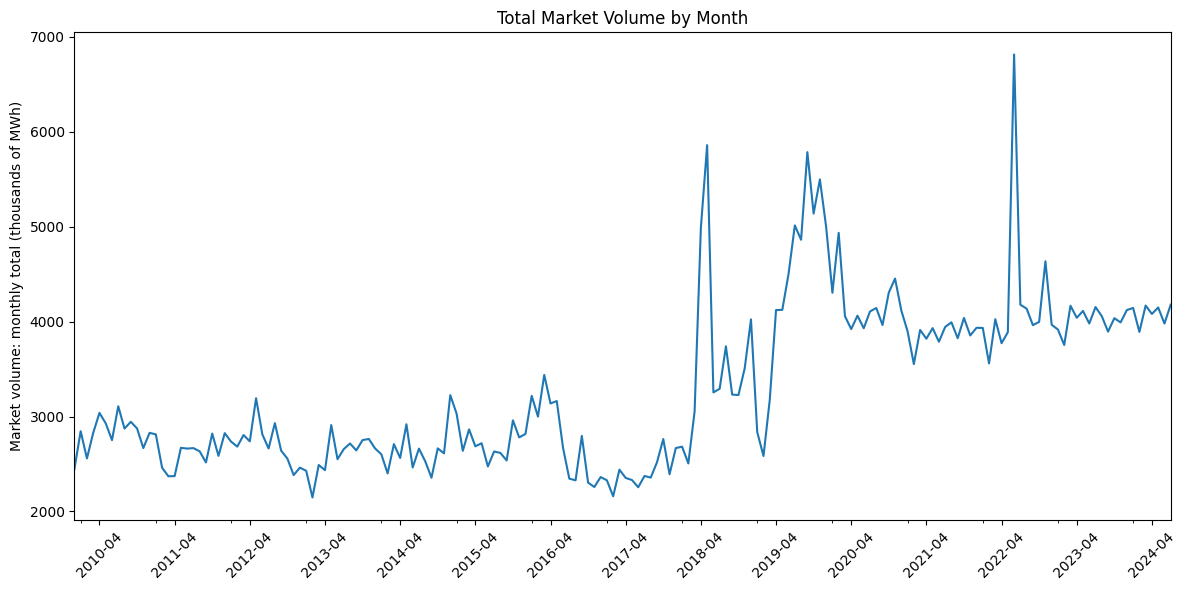

In [17]:
# Total market volume 

# 1) Convert index to a proper datetime index if it's still strings like 'YYYY-MM'
monthly_sums.index = pd.to_datetime(monthly_sums.index, format='%Y-%m')

# 2) Ensure RAISEREG and LOWERREG are in thousands of MWh
#    (Adjust this step according to your scaling needs.)
monthly_sums_scaled = monthly_sums.copy()
monthly_sums_scaled[['RAISEREG', 'LOWERREG']] /= 1000

# 3) Create a new column for total market volume
monthly_sums_scaled['TOTAL'] = monthly_sums_scaled['RAISEREG'] + monthly_sums_scaled['LOWERREG']

# 4) Plot the TOTAL volume as a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
monthly_sums_scaled['TOTAL'].plot(kind='line', figsize=(12,6))

# 5) Customize labels and title
ax.set_title("Total Market Volume by Month")
ax.set_ylabel("Market volume: monthly total (thousands of MWh)")

# 6) Set custom x-axis ticks: first label is 2010-04, then every 12 months thereafter
start_tick = pd.to_datetime('2010-04')         # first labeled tick
end_tick = monthly_sums.index.max()            # last date in the dataset
tick_dates = pd.date_range(start=start_tick, end=end_tick, freq='12M')  # every 12 months

# Ensure the plot still shows all data; we are only controlling the labeled ticks
ax.set_xticks(tick_dates)
ax.set_xticklabels([dt.strftime('%Y-%m') for dt in tick_dates], rotation=45)
ax.set_xlabel("")

plt.tight_layout()
plt.show()

In [30]:
ddf.head(5)

,SETTLEMENTDATE,DUID,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,...,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP,year_month
0,2009-12-01 00:05:00,BW01,0,0,1,416.3204,412.09,240,240,3,...,18,9.0,9.0,660,687.89526,301.58911,687.89526,301.58911,0,2009-12
1,2009-12-01 00:05:00,BW02,0,0,1,410.21045,412.09,240,240,3,...,18,9.0,7.0,660,683.84766,301.58911,683.84766,301.58911,0,2009-12
2,2009-12-01 00:05:00,BW03,0,0,1,417.33316,412.09,240,240,3,...,18,9.0,7.0,560,562.88208,309.65869,562.88208,309.65869,0,2009-12
3,2009-12-01 00:05:00,BW04,0,0,1,397.92529,396.01,240,240,3,...,18,7.0,7.0,660,669.33289,278.20544,669.33289,278.20544,0,2009-12
4,2009-12-01 00:05:00,ER01,0,0,1,594.09998,600,300,300,0,...,10,6.0,6.0,660,659.82507,349.97498,659.82507,349.97498,0,2009-12


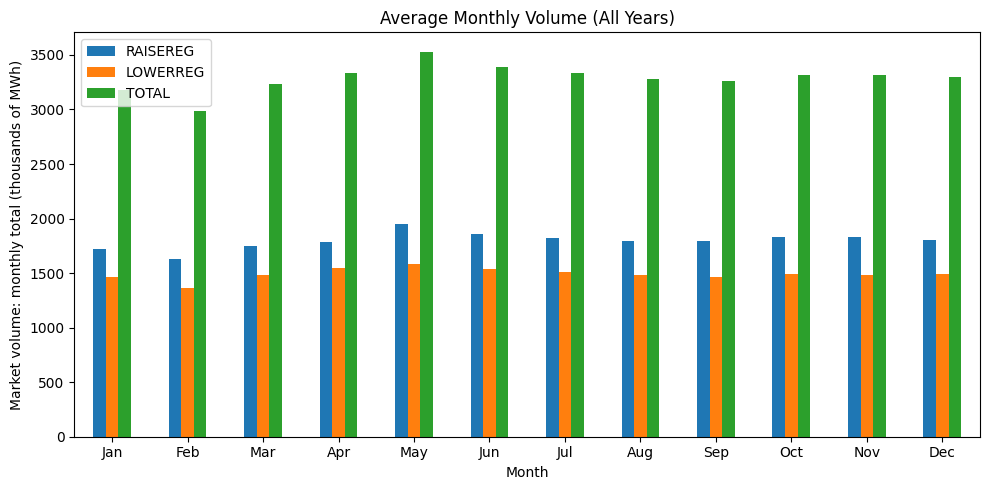

In [18]:
# 1) Ensure your index is a proper datetime index
monthly_sums.index = pd.to_datetime(monthly_sums.index, format='%Y-%m')

# 2) Create a TOTAL column if you want the combined volume
monthly_sums['TOTAL'] = monthly_sums['RAISEREG'] + monthly_sums['LOWERREG']

# 3) Make a scaled copy so volumes are in thousands of MWh (i.e., GWh)
monthly_sums_scaled = monthly_sums.copy()
monthly_sums_scaled[['RAISEREG', 'LOWERREG', 'TOTAL']] /= 1000

# 4) Extract the numeric month (1=Jan,2=Feb,...) and a short month name
monthly_sums_scaled['month_num'] = monthly_sums_scaled.index.month
monthly_sums_scaled['month_abbr'] = monthly_sums_scaled.index.month_name().str[:3]

# 5) Group by (month_num, month_abbr) and compute the average
monthly_avg = (
    monthly_sums_scaled
    .groupby(['month_num', 'month_abbr'])[['RAISEREG', 'LOWERREG', 'TOTAL']]
    .mean()
    .reset_index()
    .sort_values('month_num')  # ensures chronological order (Jan, Feb, etc.)
)

# 6) Plot a bar chart of RAISEREG, LOWERREG, and TOTAL by short month name
ax = monthly_avg.plot(
    kind='bar',
    x='month_abbr',
    y=['RAISEREG', 'LOWERREG', 'TOTAL'],
    figsize=(10, 5)
)

plt.xlabel('Month')
plt.ylabel('Market volume: monthly total (thousands of MWh)')
plt.title('Average Monthly Volume (All Years)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
# Work out the most profilic DUIDS to work out their revenue (need to match with price data as estimate)
output_dir = "/Volumes/T7/dispatch_data"

# 1) Group by DUID and sum RAISEREG and LOWERREG
duid_sums = ddf.groupby('DUID')[['RAISEREG', 'LOWERREG']].sum().compute()

# 2) Create a column for total REG
duid_sums['TOTALREG'] = duid_sums['RAISEREG'] + duid_sums['LOWERREG']

# 3) Find the top 10 DUIDs for each measure
top30_raise = duid_sums.nlargest(30, 'RAISEREG')
top30_lower = duid_sums.nlargest(30, 'LOWERREG')
top30_total = duid_sums.nlargest(30, 'TOTALREG')

print("Top 10 DUID by RAISEREG:")
print(top30_raise)

print("\nTop 10 DUID by LOWERREG:")
print(top30_lower)

print("\nTop 10 DUID by TOTALREG (RAISEREG + LOWERREG):")
print(top30_total)

top30_raise.to_parquet(os.path.join(output_dir, "top10_raise.parquet"))
top30_lower.to_parquet(os.path.join(output_dir, "top10_lower.parquet"))
top30_total.to_parquet(os.path.join(output_dir, "top10_total.parquet"))

Top 10 DUID by RAISEREG:
              RAISEREG      LOWERREG      TOTALREG
DUID                                              
HPRG1     1.531708e+07  8.567010e+04  1.540275e+07
GORDON    1.233578e+07  5.283705e+06  1.761949e+07
BW02      1.123244e+07  8.555857e+06  1.978830e+07
BW01      1.094170e+07  8.708339e+06  1.965004e+07
BW03      1.057701e+07  7.955417e+06  1.853243e+07
BW04      8.928488e+06  6.638276e+06  1.556676e+07
POAT220   8.730493e+06  4.118443e+06  1.284894e+07
GSTONE4   8.695915e+06  4.882825e+06  1.357874e+07
GSTONE3   8.172975e+06  4.652404e+06  1.282538e+07
GSTONE6   7.986112e+06  4.834147e+06  1.282026e+07
GSTONE5   7.657967e+06  4.524401e+06  1.218237e+07
ER04      6.969250e+06  6.200765e+06  1.317001e+07
GSTONE2   6.923058e+06  4.035294e+06  1.095835e+07
ER01      6.887077e+06  5.954798e+06  1.284187e+07
ER02      6.850749e+06  5.693658e+06  1.254441e+07
ER03      6.730666e+06  5.546578e+06  1.227724e+07
GSTONE1   6.582314e+06  3.621828e+06  1.020414e+07
STAN-3

In [ ]:
# Download the latest Generators and Scheduled Loads table. The 
# update_static_file=True argument forces nemosis to download a new copy of 
# file from AEMO even if a copy already exists in the cache.
dispatch_units = static_table(table_name='Generators and Scheduled Loads', 
                              raw_data_location=raw_data_cache,
                              update_static_file=False)
dispatch_units.head()

# To do

- Basically calculate market share in the industry
- Find how many BM units the largest firms own - need more than just top ten as the same power station is in lots
- Coal/gas prices etc
- Work out total price - this will be computationally challenging as on 5 minute basis
- Need to explore the story about what changed in 2015 Q4 - that's the premise of the whole story
- Need to start writing the set-up
- Learn more about how the demand estimation and learning models work - that's the *economics*
- do you calculate HHI over time?
- Number of active stations in each month - just do unique in the ddf
- Multiply price * dispatch to find revenue

In [ ]:
# This was run originally to download the data
# dispatch_load_df = dynamic_data_compiler(start_time='2023/07/01 00:00:00',
#                                    end_time='2024/09/01 00:00:00',
#                                    table_name='DISPATCHLOAD',
#                                    raw_data_location=raw_data_cache
#                                     )
# dispatch_load_df

In [ ]:
# This was run originally to concatenate the data once downloaded into parquet files
# data_dir = "/Volumes/T7/NEMO_data"
# feather_files = sorted(glob(os.path.join(data_dir, "PUBLIC_DVD_DISPATCHLOAD_*.feather")))
# print(f"Found {len(feather_files)} Feather files to load.")

# batch_size = 10
# dfs = []
# batch_count = 1  # We'll increment this each time we save a batch

# for i, file in enumerate(feather_files):
#     df = pd.read_feather(file)
#     dfs.append(df)

#     if (i + 1) % batch_size == 0 or i == len(feather_files) - 1:
#         # Save current batch
#         batch_df = pd.concat(dfs, ignore_index=True)
#         batch_df.to_parquet(f"batch_{batch_count}.parquet")
        
#         # Clean up memory
#         del dfs, batch_df
#         dfs = []
        
#         print(f"Saved batch_{batch_count}.parquet with {i+1} files processed.")
#         batch_count += 1

# print("All batches saved. Now reloading everything.")

# # Reload them in order
# batch_files = sorted(glob("batch_*.parquet"))
# final_df = pd.concat([pd.read_parquet(bf) for bf in batch_files], ignore_index=True)
# print(f"Final dataset: {final_df.shape[0]} rows and {final_df.shape[1]} columns.")